## Import Libraries

In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, csc_matrix, hstack, save_npz, load_npz

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize

from sklearn.neighbors import KNeighborsClassifier

## Load Raw Data

### Warning!: Data is Heavy

In [307]:
# using converters parameter to read strings as lists or dictionaries
credits_df = pd.read_csv("credits.csv", low_memory=False, converters={"cast": eval, "crew": eval})
keywords_df = pd.read_csv("keywords.csv", low_memory=False, converters={"keywords": eval})
links_df = pd.read_csv("links.csv")

In [308]:
def eval_with_nan(x):
    if x:
        return eval(x)
    else:
        return None
    
movies_df = pd.read_csv("movies_metadata.csv", low_memory=False, converters={"production_companies": eval_with_nan, "genres": eval})

## Explore Data

### credits_df

In [309]:
credits_df.memory_usage()

Index       128
cast     363808
crew     363808
id       363808
dtype: int64

In [310]:
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [311]:
credits_df["cast"][34][3]

{'cast_id': 6,
 'character': 'Gerald Brenan',
 'credit_id': '52fe471bc3a36847f8123ab5',
 'gender': 2,
 'id': 54447,
 'name': 'Samuel West',
 'order': 3,
 'profile_path': '/yIDXDpgXxPbl5qWu8KHV7fGzVNr.jpg'}

In [312]:
credits_df["crew"][0][0] #director

{'credit_id': '52fe4284c3a36847f8024f49',
 'department': 'Directing',
 'gender': 2,
 'id': 7879,
 'job': 'Director',
 'name': 'John Lasseter',
 'profile_path': '/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg'}

### Movies_df

In [313]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [314]:
movies_df[movies_df["original_title"].str.contains("Star Wars")]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
256,False,"{'id': 10, 'name': 'Star Wars Collection', 'po...",11000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.starwars.com/films/star-wars-episod...,11,tt0076759,en,Star Wars,Princess Leia is captured and held hostage by ...,...,1977-05-25,7.753980e+08,121.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"A long time ago in a galaxy far, far away...",Star Wars,False,8.1,6778.0
2514,False,"{'id': 10, 'name': 'Star Wars Collection', 'po...",115000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.starwars.com/films/star-wars-episod...,1893,tt0120915,en,Star Wars: Episode I - The Phantom Menace,"Anakin Skywalker, a young slave strong with th...",...,1999-05-19,9.243176e+08,136.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Every generation has a legend. Every journey h...,Star Wars: Episode I - The Phantom Menace,False,6.4,4526.0
5244,False,"{'id': 10, 'name': 'Star Wars Collection', 'po...",120000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.starwars.com/films/star-wars-episod...,1894,tt0121765,en,Star Wars: Episode II - Attack of the Clones,"Ten years after the invasion of Naboo, the gal...",...,2002-05-15,6.493983e+08,142.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Jedi Shall Not Know Anger. Nor Hatred. Nor L...,Star Wars: Episode II - Attack of the Clones,False,6.4,4074.0
10069,False,"{'id': 10, 'name': 'Star Wars Collection', 'po...",113000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://www.starwars.com/films/star-wars-episod...,1895,tt0121766,en,Star Wars: Episode III - Revenge of the Sith,"Years after the onset of the Clone Wars, the n...",...,2005-05-17,8.500000e+08,140.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The saga is complete.,Star Wars: Episode III - Revenge of the Sith,False,7.1,4200.0
12885,False,NaN,8500000,"[{'id': 53, 'name': 'Thriller'}, {'id': 16, 'n...",http://www.starwars.com/clonewars/site/index.html,12180,tt1185834,en,Star Wars: The Clone Wars,Set between Episode II and III the Clone Wars ...,...,2008-08-05,6.828284e+07,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Star Wars: The Clone Wars,False,5.8,434.0
15453,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,76180,tt0416716,en,Empire of Dreams: The Story of the Star Wars T...,Empire of Dreams: The Story of the Star Wars T...,...,2004-09-12,0.000000e+00,151.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Empire of Dreams: The Story of the Star Wars T...,False,7.1,22.0
26555,False,"{'id': 10, 'name': 'Star Wars Collection', 'po...",245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.starwars.com/films/star-wars-episod...,140607,tt2488496,en,Star Wars: The Force Awakens,Thirty years after defeating the Galactic Empi...,...,2015-12-15,2.068224e+09,136.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Every generation has a story.,Star Wars: The Force Awakens,False,7.5,7993.0
30434,False,NaN,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",NaN,74849,tt0193524,en,The Star Wars Holiday Special,Luke Skywalker and Han Solo battle evil Imperi...,...,1978-12-01,0.000000e+00,97.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"A long time ago, in a galaxy far, far away...",The Star Wars Holiday Special,False,3.2,81.0
30904,False,"{'id': 141748, 'name': 'Robot Chicken: Star Wa...",0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,42979,tt1020990,en,Robot Chicken: Star Wars,"Fans of Adult Swim's ""Robot Chicken"" and the S...",...,2007-07-17,0.000000e+00,23.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Spend Father's Day with who really raised you....,Robot Chicken: Star Wars,True,6.9,58.0
35833,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",http://www.plasticgalaxymovie.

In [315]:
movies_df["original_language"].value_counts()[:10]

en    32269
fr     2438
it     1529
ja     1350
de     1080
es      994
ru      826
hi      508
ko      444
zh      409
Name: original_language, dtype: int64

In [316]:
movies_df["overview"][34]

"The story of the relationship between painter Dora Carrington and author Lytton Strachey in a World War One England of cottages and countryside. Although platonic due to Strachey's homosexuality, the relationship was nevertheless a deep and complicated one. When Carrington did develop a more physical relationship with soldier Ralph Partridge, Strachey was able to welcome him as a friend, although Partridge remained somewhat uneasy, not so much with Strachey's lifestyle and sexual orientation as with the fact that he was a conscientious objector."

In [317]:
movies_df["tagline"][24]

'I Love You... The Way You Are.'

<IPython.core.display.Javascript object>


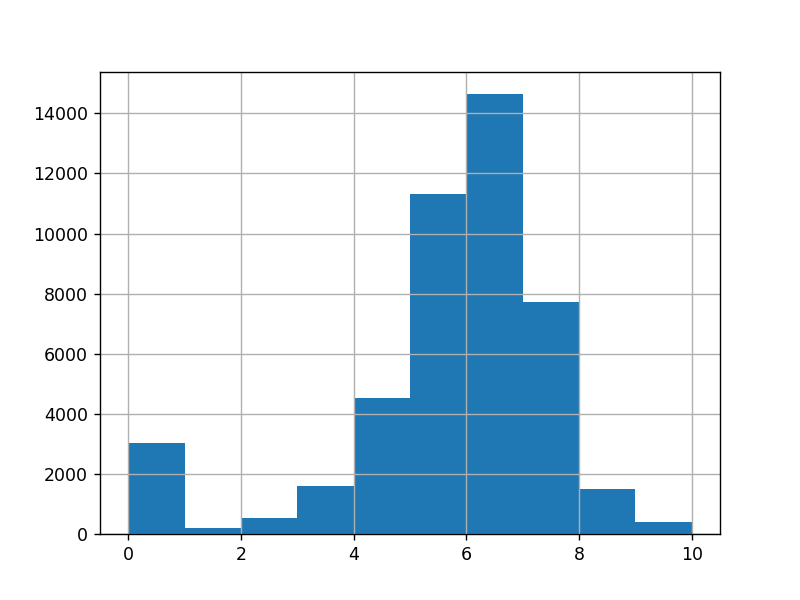

In [318]:
plt.figure()
movies_df["vote_average"].hist()

In [319]:
movies_df[movies_df["vote_average"] < 5].head(50)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
36,False,NaN,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 36, '...",NaN,139405,tt0112286,en,Across the Sea of Time,"A young Russian boy, Thomas Minton, travels to...",...,1995-10-20,0.0,51.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}, {'iso...",Released,NaN,Across the Sea of Time,False,3.5,2.0
55,False,NaN,0,[],NaN,124057,tt0113541,en,Kids of the Round Table,"Set in modern times, Alex finds King Arthur's ...",...,1997-07-08,0.0,89.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Kids of the Round Table,False,3.0,1.0
63,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,19760,tt0118002,en,Two If by Sea,"Frank O'Brien, a petty thief, and his 7-year-l...",...,1996-01-12,0.0,96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"A new comedy about love, laughter, and larceny",Two If by Sea,False,4.5,14.0
64,False,NaN,15000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,9536,tt0115683,en,Bio-Dome,Bud and Doyle are two losers who are doing not...,...,1996-01-12,0.0,88.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Bud and Doyle are here to save the world. But ...,Bio-Dome,False,4.4,110.0
65,False,"{'id': 124935, 'name': 'The Lawnmower Man Coll...",0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",NaN,11525,tt0116839,en,Lawnmower Man 2: Beyond Cyberspace,Jobe is resuscitated by Jonathan Walker. He wa...,...,1996-01-12,2409225.0,92.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,God made him simple. Science made him a god. N...,Lawnmower Man 2: Beyond Cyberspace,False,2.8,32.0
70,False,NaN,50000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,11859,tt0113010,en,Fair Game,Max Kirkpatrick is a cop who protects Kate McQ...,...,1995-11-03,11534477.0,91.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,He's a cop on the edge. She's a woman with a d...,Fair Game,False,4.1,54.0
74,False,NaN,15000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",NaN,36929,tt0115676,en,Big Bully,A writer returns to his hometown where he face...,...,1996-01-26,2042530.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A comedy for the kid in all of us.,Big Bully,False,3.9,16.0
82,False,NaN,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,146599,tt0114039,en,Once Upon a Time... When We Were Colored,This film relates the story of a tightly conne...,...,1996-01-26,0.0,115.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Once Upon a Time... When We Were Colored,False,4.5,2.0
83,False,NaN,0,[],NaN,188588,tt0113612,en,Last Summer in the Hamptons,"Filmed entirely on location in East Hampton, L...",...,1995-11-22,0.0,108.0,[],Released,NaN,Last Summer in the Hamptons,False,0.0,0.0
91,False,NaN,14000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,12158,tt0114825,en,Vampire in Brooklyn,"Maximillian, the lone survivor of a race of va...",...,1995-10-26,19800000.0,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A comic tale of horror and seduction.,Vampire in Brooklyn,False,4.5,113.0


In [320]:
movies_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [321]:
movies_df[["popularity", "poster_path", "production_companies", "production_countries"]]

,popularity,poster_path,production_companies,production_countries
0,21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o..."
1,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o..."
2,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o..."
3,3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o..."
4,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o..."
...,...,...,...,...
45461,0.072051,/jldsYflnId4tTWPx8es3uzsB1I8.jpg,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]"
45462,0.178241,/xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]"
45463,0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o..."
45464,0.003503,/aorBPO7ak8e8iJKT5OcqYxU3jlK.jpg,"[{'name': 'Yermoliev', 'id': 88753}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]"


In [322]:
movies_df["production_companies"][0][0]["name"]

'Pixar Animation Studios'

In [323]:
movies_df["belongs_to_collection"]

0        {'id': 10194, 'name': 'Toy Story Collection', ...
1                                                      NaN
2        {'id': 119050, 'name': 'Grumpy Old Men Collect...
3                                                      NaN
4        {'id': 96871, 'name': 'Father of the Bride Col...
                               ...                        
45461                                                  NaN
45462                                                  NaN
45463                                                  NaN
45464                                                  NaN
45465                                                  NaN
Name: belongs_to_collection, Length: 45466, dtype: object

### keywords_df

In [324]:
keywords_df.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [325]:
keywords_df["keywords"][0]

[{'id': 931, 'name': 'jealousy'},
 {'id': 4290, 'name': 'toy'},
 {'id': 5202, 'name': 'boy'},
 {'id': 6054, 'name': 'friendship'},
 {'id': 9713, 'name': 'friends'},
 {'id': 9823, 'name': 'rivalry'},
 {'id': 165503, 'name': 'boy next door'},
 {'id': 170722, 'name': 'new toy'},
 {'id': 187065, 'name': 'toy comes to life'}]

## Data Cleaning

### Process Movies df

In [326]:
movies_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

#### Thresh by vote average by value 5

In [329]:
movies_df = movies_df[movies_df["vote_average"] > 5.5]

In [330]:
movies_df.shape

(28860, 24)

#### Thresh by vote count by value 10

In [331]:
movies_df = movies_df[movies_df["vote_count"] > 50]

In [332]:
movies_df.shape

(7440, 24)

#### drop unnecessary columns

In [333]:
drop_cols = ["adult", "imdb_id", "belongs_to_collection", "production_countries", "homepage", "poster_path", 
             "video", "status", "spoken_languages"]

movies_df.drop(columns=drop_cols, axis=1, inplace=True)

#### fill nan values

In [334]:
movies_df.isnull().sum()

budget                     0
genres                     0
id                         0
original_language          0
original_title             0
overview                  24
popularity                 0
production_companies       0
release_date               1
revenue                    0
runtime                    1
tagline                 1707
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [335]:
mean_fillna = ["runtime"]
for c in mean_fillna:
    movies_df[c].fillna(movies_df[c].mean(), inplace=True)

In [336]:
movies_df["original_language"].value_counts().idxmax()

'en'

In [337]:
most_frequent_fillna = ["original_language", "release_date"]
for c in most_frequent_fillna:
    frequent = movies_df[c].value_counts().idxmax()
    movies_df[c].fillna(frequent, inplace=True)

In [338]:
# fill with empty string
fill_empty = ["overview", "tagline"]
for c in fill_empty:
    movies_df[c].fillna("", inplace=True)

In [339]:
movies_df.head(2)

,budget,genres,id,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,tagline,title,vote_average,vote_count
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",1995-10-30,373554033.0,81.0,,Toy Story,7.7,5415.0
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",1995-12-15,262797249.0,104.0,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0


In [340]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7440 entries, 0 to 45437
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                7440 non-null   object 
 1   genres                7440 non-null   object 
 2   id                    7440 non-null   object 
 3   original_language     7440 non-null   object 
 4   original_title        7440 non-null   object 
 5   overview              7440 non-null   object 
 6   popularity            7440 non-null   object 
 7   production_companies  7440 non-null   object 
 8   release_date          7440 non-null   object 
 9   revenue               7440 non-null   float64
 10  runtime               7440 non-null   float64
 11  tagline               7440 non-null   object 
 12  title                 7440 non-null   object 
 13  vote_average          7440 non-null   float64
 14  vote_count            7440 non-null   float64
dtypes: float64(4), objec

#### Production Companies

In [341]:
movies_df["production_companies"] = movies_df["production_companies"].apply(lambda x: "" if not x else x[0]["name"])

#### genres

In [342]:
#convert to genres list
movies_df["genres"] = movies_df["genres"].apply(lambda x: [] if not x else [i["name"] for i in x])

#### converting to float

In [343]:
to_float = ["budget", "popularity"]
movies_df[to_float] = movies_df[to_float].astype(float)

#### Date to Year

In [344]:
movies_df["release_date"] = movies_df["release_date"].apply(lambda x: int(x[:4]))

#### id to int

In [345]:
movies_df["id"] = movies_df["id"].astype(int)

In [346]:
movies_df.head(2)

,budget,genres,id,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,tagline,title,vote_average,vote_count
0,30000000.0,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,1995,373554033.0,81.0,,Toy Story,7.7,5415.0
1,65000000.0,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,TriStar Pictures,1995,262797249.0,104.0,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0


### Process credits df

In [347]:
credits_df.isnull().sum()

cast    0
crew    0
id      0
dtype: int64

In [348]:
credits_df.head(2)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844


In [349]:
credits_df["crew"][0]

[{'credit_id': '52fe4284c3a36847f8024f49',
  'department': 'Directing',
  'gender': 2,
  'id': 7879,
  'job': 'Director',
  'name': 'John Lasseter',
  'profile_path': '/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f4f',
  'department': 'Writing',
  'gender': 2,
  'id': 12891,
  'job': 'Screenplay',
  'name': 'Joss Whedon',
  'profile_path': '/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f55',
  'department': 'Writing',
  'gender': 2,
  'id': 7,
  'job': 'Screenplay',
  'name': 'Andrew Stanton',
  'profile_path': '/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f5b',
  'department': 'Writing',
  'gender': 2,
  'id': 12892,
  'job': 'Screenplay',
  'name': 'Joel Cohen',
  'profile_path': '/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f61',
  'department': 'Writing',
  'gender': 0,
  'id': 12893,
  'job': 'Screenplay',
  'name': 'Alec Sokolow',
  'profile_path': '/v79vlRYi94BZUQnkkyzn

#### Pull Directors

In [350]:
# directors
credits_df["director"] = credits_df["crew"].apply(lambda x: "" if not x else x[0]["name"])

In [351]:
director_counts = credits_df["director"].value_counts()
credits_df["count"] = credits_df["director"].apply(lambda x: director_counts.loc[x])

In [352]:
credits_df.loc[(credits_df["count"] < 10), "director"] = ""

In [353]:
credits_df.head(3)

,cast,crew,id,director,count
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,John Lasseter,29
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,,5
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,,6


In [354]:
credits_df["director"].value_counts()

                   35993
Avy Kaufman          124
Ennio Morricone       81
Suzanne Smith         69
Roger Corman          66
                   ...  
Ted J. Kent           10
Neri Parenti          10
Marcel Pagnol         10
John Pilger           10
Ken Burns             10
Name: director, Length: 557, dtype: int64

#### Pull actors

In [355]:
def return_actors(x):
    actors = []
    i = 0
    while (i < 3 and i < len(x)):
        actors.append(x[i]["name"])
        i+=1
    return actors

credits_df["actors"] = credits_df["cast"].apply(lambda x: return_actors(x))

In [356]:
# actor_set = set()
# for i, r in credits_df.iterrows():
#     for a in r["actors"]:
#         actor_set.add(a)
# print(len(actor_set))

In [357]:
credits_df = credits_df[["id", "director", "actors"]]
credits_df.head()

,id,director,actors
0,862,John Lasseter,"[Tom Hanks, Tim Allen, Don Rickles]"
1,8844,,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]"
2,15602,,"[Walter Matthau, Jack Lemmon, Ann-Margret]"
3,31357,,"[Whitney Houston, Angela Bassett, Loretta Devine]"
4,11862,Alan Silvestri,"[Steve Martin, Diane Keaton, Martin Short]"


### Process Keywords df

In [358]:
keywords_df.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [359]:
# convert keywords to keywords list
keywords_df["keywords"] = keywords_df["keywords"].apply(lambda x: [i["name"] for i in x])

## Join dataframes to a Final df

In [360]:
keywords_df.shape

(46419, 2)

In [361]:
credits_df.shape

(45476, 3)

In [362]:
movies_df.shape

(7440, 15)

In [363]:
# join movies and keywords
joined = movies_df.join(keywords_df, on="id", lsuffix="", rsuffix="_to_del").drop("id_to_del", axis=1)

In [364]:
joined.head()

,budget,genres,id,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,tagline,title,vote_average,vote_count,keywords
0,30000000.0,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,1995,373554033.0,81.0,,Toy Story,7.7,5415.0,[]
1,65000000.0,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,TriStar Pictures,1995,262797249.0,104.0,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"[spy, father son relationship, traitor, murder..."
2,0.0,"[Romance, Comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,Warner Bros.,1995,0.0,101.0,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,[sport]
4,0.0,[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,Sandollar Productions,1995,76578911.0,106.0,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,"[sex, lasergun, beautiful woman, female protag..."
5,60000000.0,"[Action, Crime, Drama, Thriller]",949,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,Regency Enterprises,1995,187436818.0,170.0,A Los Angeles Crime Saga,Heat,7.7,1886.0,"[italy, nurse, love letter, officer, priest, e..."


In [365]:
# join movies (joined) and credits
joined = joined.join(credits_df, on="id", lsuffix="", rsuffix="_to_del").drop("id_to_del", axis=1)

In [366]:
joined.head()

,budget,genres,id,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,tagline,title,vote_average,vote_count,keywords,director,actors
0,30000000.0,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,1995,373554033.0,81.0,,Toy Story,7.7,5415.0,[],,"[Ad van Kempen, Ariane Schluter]"
1,65000000.0,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,TriStar Pictures,1995,262797249.0,104.0,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"[spy, father son relationship, traitor, murder...",,"[Henry Thomas, Dabney Coleman, Michael Murphy]"
2,0.0,"[Romance, Comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,Warner Bros.,1995,0.0,101.0,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,[sport],,"[María Ester Escobar, Francisco Maturana, Alex..."
4,0.0,[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,Sandollar Productions,1995,76578911.0,106.0,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,"[sex, lasergun, beautiful woman, female protag...",John Barry,"[Marjoe Gortner, Caroline Munro, Christopher P..."
5,60000000.0,"[Action, Crime, Drama, Thriller]",949,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,Regency Enterprises,1995,187436818.0,170.0,A Los Angeles Crime Saga,Heat,7.7,1886.0,"[italy, nurse, love letter, officer, priest, e...",Charles Lang,"[Helen Hayes, Gary Cooper, Adolphe Menjou]"


In [367]:
# handle director nans
joined["director"].fillna("", inplace=True)

In [368]:
# save joined df
# joined.to_csv("joined.csv")

## Movie indexes df

In [369]:
movie_indexes = pd.DataFrame(data={"title": joined["original_title"]})
movie_indexes.head()

,title
0,Toy Story
1,Jumanji
2,Grumpier Old Men
4,Father of the Bride Part II
5,Heat


In [370]:
movie_indexes.loc[movie_indexes["title"] == "Toy Story"]

,title
0,Toy Story


In [371]:
movie_indexes["title"].str.contains("Toy Story").any()

True

# Prepare Final Data

## 1) One Hot Encodings of lists

### Genres

In [372]:
genres_df = joined["genres"].str.join("|").str.get_dummies()
genres_df.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [373]:
genres_df.shape

(7440, 20)

In [374]:
genres_vec = csr_matrix(genres_df)

In [375]:
genres_vec

<7440x20 sparse matrix of type '<class 'numpy.int64'>'
	with 18815 stored elements in Compressed Sparse Row format>

In [376]:
joined.drop("genres", axis=1, inplace=True)

### Actors

In [ ]:
actors_df = joined["actors"].str.join("|").str.get_dummies()
actors_df.head()

In [103]:
joined["actors"].str.join("|").str.get_dummies()

KeyboardInterrupt: 

In [377]:
joined.drop("actors", axis=1, inplace=True)

## 2) Vectorizations

### info = tagline + overview + keywords

In [378]:
info_df = joined["tagline"] + " " + joined["overview"] + " " + joined["keywords"].str.join(" ").fillna("")

In [379]:
info_df.head()

0     Led by Woody, Andy's toys live happily in his...
1    Roll the dice and unleash the excitement! When...
2    Still Yelling. Still Fighting. Still Ready for...
4    Just When His World Is Back To Normal... He's ...
5    A Los Angeles Crime Saga Obsessive master thie...
dtype: object

In [380]:
cv = CountVectorizer(stop_words="english")
info_vec = cv.fit_transform(info_df)

In [381]:
info_vec

<7440x28455 sparse matrix of type '<class 'numpy.int64'>'
	with 241665 stored elements in Compressed Sparse Row format>

In [382]:
joined.drop(["tagline", "overview", "keywords"], axis=1, inplace=True)

## 3) Normalizations and One Hot Encodings for categories

### Split data before normalizations

In [383]:
X_df = joined.drop(["id", "title", "original_title"], axis=1)
y_df = joined.loc[:, ["id", "title", "original_title"]]

In [384]:
X_df.head()

,budget,original_language,popularity,production_companies,release_date,revenue,runtime,vote_average,vote_count,director
0,30000000.0,en,21.946943,Pixar Animation Studios,1995,373554033.0,81.0,7.7,5415.0,
1,65000000.0,en,17.015539,TriStar Pictures,1995,262797249.0,104.0,6.9,2413.0,
2,0.0,en,11.712900,Warner Bros.,1995,0.0,101.0,6.5,92.0,
4,0.0,en,8.387519,Sandollar Productions,1995,76578911.0,106.0,5.7,173.0,John Barry
5,60000000.0,en,17.924927,Regency Enterprises,1995,187436818.0,170.0,7.7,1886.0,Charles Lang


In [385]:
y_df.head()

,id,title,original_title
0,862,Toy Story,Toy Story
1,8844,Jumanji,Jumanji
2,15602,Grumpier Old Men,Grumpier Old Men
4,11862,Father of the Bride Part II,Father of the Bride Part II
5,949,Heat,Heat


In [386]:
y = y_df["title"].reset_index().drop("index", axis=1)

In [387]:
y

,title
0,Toy Story
1,Jumanji
2,Grumpier Old Men
3,Father of the Bride Part II
4,Heat
...,...
7435,The Double Lover
7436,Minions: Orientation Day
7437,Descendants 2
7438,Force Majeure


### ColumnTransformer

In [388]:
categorical_indexes = [1, 3, 9]
numerical_indexes = [0, 2, 4, 5, 6, 7, 8]

In [389]:
preprocess = ColumnTransformer(transformers=[
                                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_indexes),
                                ("num", MinMaxScaler(), numerical_indexes)])

X_vec = preprocess.fit_transform(X_df)

In [390]:
X_vec

<7440x2690 sparse matrix of type '<class 'numpy.float64'>'
	with 68002 stored elements in Compressed Sparse Row format>

# Join All Vectorized Sparse Data Matrices

### Matrices = [X_vec, genres_vec, info_vec]

In [449]:
final_vec = csc_matrix(hstack((X_vec, genres_vec, info_vec)))

In [450]:
final_vec = normalize(final_vec, norm="l2", axis=1)

In [451]:
final_vec

<7440x31165 sparse matrix of type '<class 'numpy.float64'>'
	with 328482 stored elements in Compressed Sparse Row format>

## Save Sparse Info Matrix and Titles df

In [467]:
save_npz("X_data.npz", final_vec)
y.to_csv("y_data.csv", index=False)

# LOAD FINAL DATA

In [2]:
final_vec = load_npz("X_data.npz")

In [5]:
final_vec

<7440x31165 sparse matrix of type '<class 'numpy.float64'>'
	with 328482 stored elements in Compressed Sparse Row format>

In [3]:
y = pd.read_csv("y_data.csv")

In [7]:
y.head()

,title
0,Toy Story
1,Jumanji
2,Grumpier Old Men
3,Father of the Bride Part II
4,Heat


# Create The Model

In [8]:
# fit the model
knn = KNeighborsClassifier().fit(final_vec, y.values.ravel())

### Functions

In [29]:
def get_similar_movies(movie_name, X, y, knn, n_movies=10):
    index = y.loc[y["title"].str.lower() == movie_name].index[0]
    movie_data = X[index, :].toarray()
    distances, indices = knn.kneighbors(movie_data, n_neighbors=n_movies+1)
    
    movies = []
    for i in np.squeeze(indices):
        movie = y.iloc[i]["title"]
        movies.append(movie)
    
    return movies[1:]

In [43]:
def main(X, y, knn):
    run = True
    while run:
        movie_name = input("\nEnter movie name to find similar movies (q to quit): ")
        
        if movie_name == "q":
            run = False
            continue
        
        movie_name = movie_name.lower()
        
        # name is in dataset
        if movie_name in y["title"].str.lower().values:
            n_movies = int(input("How many similar movies (integer): "))
            movies = get_similar_movies(movie_name, X, y, knn, n_movies=n_movies)
            
            # inform user
            print("\nSimilar Movies:")
            for i, movie in enumerate(movies):
                print(str(i+1) + ". " + movie)
        
        # some movie names contains searched movie name
        elif y["title"].str.lower().str.contains(movie_name).any():
            similar_names = y[y["title"].str.lower().str.contains(movie_name)].values.ravel()
            # print similar names
            #similar_names_function()
            print("Movie: \"{}\" is not founded!".format(movie_name))
            print("Similar Movie Names you can look:")
            for i, movie in enumerate(similar_names):
                print(str(i+1) + ". " + movie)
        
        # not founded at all
        else:
            print("Movie: \"{}\" or a similar movie name is not founded!".format(movie_name))
            print("Try Again.")

In [ ]:
main(final_vec, y, knn)


Enter movie name to find similar movies (q to quit): the inception
Movie: "the inception" or a similar movie name is not founded!
Try Again.


Enter movie name to find similar movies (q to quit): inception
How many similar movies (integer): 10

Similar Movies:
1. X-Men Origins: Wolverine
2. Doctor Strange
3. Mission: Impossible - Rogue Nation
4. Abduction
5. Morgan
6. The Fifth Element
7. The Hunger Games: Mockingjay - Part 1
8. Guardians of the Galaxy Vol. 2
9. X-Men: The Last Stand
10. Guardians of the Galaxy

Enter movie name to find similar movies (q to quit): klaus
Movie: "klaus" or a similar movie name is not founded!
Try Again.


Enter movie name to find similar movies (q to quit): claus
Movie: "claus" is not founded!
Similar Movie Names you can look:
1. The Santa Clause
2. Santa Claus: The Movie
3. Santa Claus Is a Stinker
4. The Santa Claus Gang

Enter movie name to find similar movies (q to quit): pokemon
Movie: "pokemon" or a similar movie name is not founded!
Try Again.




In [ ]:
movie_name = "Life Is Beautiful"
index = y.loc[y["title"] == movie_name].index[0]
movie_data = final_vec[index, :].toarray()
distances, indices = knn.kneighbors(movie_data, n_neighbors=10)

movies = []
for i in np.squeeze(indices):
    movie = y.iloc[i]["title"]
    movies.append(movie)

In [24]:
"Toy Story" in y["title"].values

True

In [37]:
y[y["title"].str.contains("Life Is")]

,title
1014,Life Is Beautiful
3158,Life Is a Long Quiet River


In [22]:
movie_name = "sherlock holmes"
y[y["title"].str.lower().str.contains(movie_name.lower())]

,title
1071,Young Sherlock Holmes
2513,The Private Life of Sherlock Holmes
4504,Sherlock Holmes
5067,Sherlock Holmes: A Game of Shadows


In [494]:
movie_name = "Life Is Beautiful"
index = y.loc[y["title"] == movie_name].index[0]
movie_data = final_vec[index, :].toarray()
distances, indices = knn.kneighbors(movie_data, n_neighbors=10)

movies = []
for i in np.squeeze(indices):
    movie = y.iloc[i]["title"]
    movies.append(movie)

In [495]:
y.iloc[5]["title"]

'Sabrina'

In [497]:
movies

['Life Is Beautiful',
 "Schindler's List",
 "Cassandra's Dream",
 'The Counterfeiters',
 'Testament of Youth',
 'Loose Cannons',
 'The Tiger and the Snow',
 'Little Boy',
 'Caramel',
 'Pinocchio']

In [481]:
distances

array([[2.35608046e-08, 1.19987548e+00, 1.20360661e+00, 1.20751940e+00,
        1.21622850e+00, 1.22769919e+00, 1.22829567e+00, 1.22978085e+00,
        1.23110785e+00, 1.23146207e+00]])

In [477]:
indices

array([[1014,  241, 4010, 4043, 6456, 4952, 3675, 6536, 4026, 2392]],
      dtype=int64)

In [260]:
index

0

In [284]:
final_vec[0, :].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])